In [114]:
#Quantum Neural Network for MNIST Classification (0 vs 1)
# All the imports that would be needed for the code to run!
# Import PennyLane (Quantum library) and its NumPy version
import pennylane as qml
from pennylane import numpy as np
# Import PyTorch for machine learning utilities
import torch 
import torchvision 
from torchvision import transforms 
from torch.utils.data import DataLoader, Subset
#-----------------------------


In [115]:
import matplotlib.pyplot as plt

# Show 2x2 input image with label + prediction
def visualize_input(x_tensor, y_true=None, y_pred=None):
    img = x_tensor.squeeze().numpy().reshape(28, 28)
    plt.imshow(img, cmap='gray')
    title = ""
    if y_true is not None:
        title += f"Label: {int(y_true)}"
    if y_pred is not None:
        title += f", Predicted: {int(y_pred)}"
    plt.title(title)
    plt.axis('off')
    plt.show()

# Show bar chart of prediction confidence (for binary classification)
def plot_binary_probability(output_tensor):
    prob = torch.sigmoid(output_tensor).item()
    plt.bar(["Class 0", "Class 1"], [1 - prob, prob], color=['blue', 'orange'])
    plt.title("Predicted Probabilities")
    plt.ylabel("Probability")
    plt.ylim(0, 1.1)
    plt.text(0, 1 - prob + 0.02, f"{1 - prob:.2f}", ha='center')
    plt.text(1, prob + 0.02, f"{prob:.2f}", ha='center')
    plt.show()


In [116]:
# ----------------------------
# Data Loading and Preprocessing
# ----------------------------
#Load MNIST and reduce to digits 0 and 1
#Define a transformation: convert images to tensors and normalize pixel values to [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
#-----------------------------

In [117]:
#Filter digits 0 and 1 only
# Create a function to filter the dataset
# This function filters the dataset to keep only samples with labels 0 or 1
def filter_digits(dataset):
    idx = (dataset.targets ==0) | (dataset.targets ==1)
    # Keep samples where label is 0 or 1
    dataset.targets = dataset.targets[idx]
    return dataset

#----------------------------

In [118]:
train_data = filter_digits(train_data)
test_data = filter_digits(test_data)
#Downsample images to 4x4 = 16 pixels (for 4 qubits)
#(Since using 4 qubits, each qubit gets 1 feature)
#Downsample function to reduce the image size
def downsample(img):
    img = img.unsqueeze(0).unsqueeze(0).float()# (1, 1, 28, 28)
    downsampled = torch.nn.functional.interpolate(#Downsample the image
        img, 
        size=(4, 4),
        mode='bilinear',
        align_corners=False
    )
    return downsampled.squeeze()  # back to (4, 4)


# Create a custom dataset to prepare quantum-friendly input
class QuantumMNISTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        # Save data as a list of (image, label) pairs after filtering
        self.data = [(img, label) for img, label in zip(dataset.data, dataset.targets)]
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = img.float()  # Convert Byte tensor to Float
        # If your image is loaded as (28, 28) already, you can proceed.
        # If it comes with a channel dimension (e.g. (1, 28, 28)), remove it:
        if img.ndim == 3:
            img = img.squeeze(0)  # Now img is [28, 28]
        
        # Aggregate each row (you could also try averaging columns)
        features = torch.mean(img, dim=1)  # Now features is a vector of length 28
        
        # Normalize the feature vector
        features = features / (torch.norm(features) + 1e-10)
        return features, label
batch_size = 10 # giving a batch size of 10

#Create data loaders for training and testing
train_loader = DataLoader(QuantumMNISTDataset(train_data), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(QuantumMNISTDataset(test_data), batch_size=batch_size)

#-----------------------------

In [119]:
# ----------------------------
# Quantum Circuit Definition
# ----------------------------
# This is the quantum circuit that will be used for classification
# Set the number of qubits
n_qubits = 28 #Setting the number of qubits
# Initialize a quantum device (simulator)
dev = qml.device("default.qubit", wires=n_qubits)
# Encode classical input into quantum states using rotations
def angle_embedding(x):
    for i in range(n_qubits):
        qml.RY(x[i],wires=i) #Apply rotation around Y-axis
#Variational quantum layer (parameterized by weights)
def variational_block(weights):
    for i in range(n_qubits):
        qml.Rot(*weights[i], wires=i)  # Apply rotation with 3 parameters (X, Y, Z)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])      # Add entanglement between neighboring qubits
# Define the full quantum node (circuit + measurements)
@qml.qnode(dev, interface="torch")
def quantum_net(inputs, weights):
    angle_embedding(inputs)    # Embed the 28 features
    variational_block(weights)   # Apply the variational layer
    return qml.expval(qml.PauliZ(0))  # Return one scalar expectation
# ----------------------------

In [120]:
# ----------------------------
# Defining the Full Quantum Neural Network in PyTorch
# ----------------------------
#Define Torch Layer
class QNet(torch.nn.Module): #This is a PyTorch module
    def __init__(self): #Initialize the module with parameters
        super().__init__()# Call the parent constructor
        # Initialize the weights for the quantum circuit
        # The weights are the parameters of the quantum circuit
        weight_shapes = (n_qubits, 3)  # 3 parameters (angles) per qubit
        self.q_params = torch.nn.Parameter(torch.randn(weight_shapes) * 0.01) 
         # self.q_params is a learnable parameter
    def forward(self, x): #Forward pass through the quantum circuit
 # x is now a batch of vectors, each of length 28.
        # For each sample we call the quantum circuit to produce a single scalar.
        # The stacking returns a tensor of shape [batch_size]
        return torch.stack([quantum_net(x[i], self.q_params) for i in range(x.shape[0])]).squeeze()


In [ ]:

# Defining the model, loss function, and optimizer
model = QNet()  # Instantiate the quantum model

# Set up optimizer (Adam) with a learning rate of 0.1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)  # Or even try 1e-3 if needed

# Binary Cross-Entropy with Logits Loss is used for binary classification
loss_fn = torch.nn.BCEWithLogitsLoss()

# Number of training epochs
epochs = 5

# Training loop over epochs
for epoch in range(epochs):
    for x_batch, y_batch in train_loader:
        y_batch = y_batch.float()     # Convert labels to float (for BCE Loss)
        preds = model(x_batch)   # Forward pass: get predictions from the QNN
         # Debugging output to check tensor shapes
        print("Preds shape:", preds.shape)  # Should be [batch_size] (e.g., [10])
        print("y_batch shape:", y_batch.shape)  # Should also be [batch_size] (e.g., [10])
        loss = loss_fn(preds, y_batch)   # Compute loss by comparing predictions and true labels
        optimizer.zero_grad()     # Reset gradients before backpropagation
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Sanity check
        # Clip gradients to prevent exploding gradients
        loss.backward()   # Backward pass: compute gradients
        optimizer.step()    # Update model parameters using optimizer
    print(f"Epoch {epoch+1}, Loss= {loss.item():.4f}")  # Print training loss for each epoch


In [ ]:
# ----------------------------
# Model Evaluation (Testing)
# ----------------------------

correct = 0
total = 0
# Disable gradient calculations for testing
with torch.no_grad(): # Disable gradient calculations
    for x_batch, y_batch in test_loader: #Iterate over test data
        outputs = model(x_batch).squeeze() #Get model outputs 
        # Apply sigmoid activation function to outputs
        # Convert outputs to binary predictions (0 or 1)
        predicted = (torch.sigmoid(outputs) > 0.5).int()  
        # Apply sigmoid then threshold at 0.5 
        correct += (predicted == y_batch).sum().item()   
        # Count correct predictions
        total += y_batch.size(0)    # Total number of samples
#Print final accuracy 
print(f"Test Accuracy: {correct/total:.2%}")


Test Accuracy: 53.66%


ValueError: only one element tensors can be converted to Python scalars

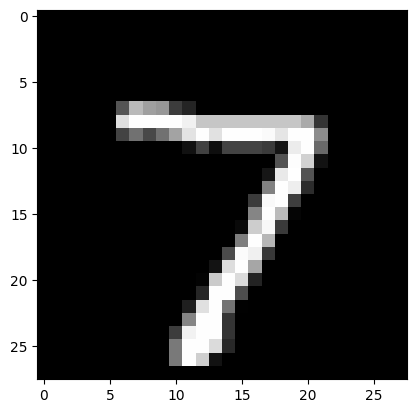

In [ ]:
# Sanity check: visualize inputs and predictions
model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Turn off gradients
    for x_batch, y_batch in test_loader:
        outputs = model(x_batch).squeeze()
        preds = (torch.sigmoid(outputs) > 0.5).int()

        for i in range(len(x_batch)):
            # Show input as image
            visualize_input(x_batch[i], y_true=y_batch[i], y_pred=preds[i])

            # Show prediction confidence
            plot_binary_probability(outputs[i])

        break  # Only one batch for demo
